In [1]:
import h5py
import numpy as np
from ImageSliceViewer3D import *
import tomopy
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

First we load the data

In [2]:
filename = "data/34_Aupart-wtflat_PHpos_/34_Aupart-wtflat_PHpos_001.h5"
#filename = "data/39_Human-1-nostain_area2_PHpos_/39_Human-1-nostain_area2_PHpos_.h5"
data_key = "exchange/data/"
projs = np.zeros((600,1110,1120), dtype='uint16')
#projs = np.zeros((1500,1110,1120), dtype='uint16')
with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(projs)

In [3]:
print(f'(Loaded data of shape {projs.shape}:')
ImageSliceViewer3D(projs)

(Loaded data of shape (600, 1110, 1120):


Then we load flat fields and dark fields - can these just be loaded from any dataset??:

In [4]:
filename = "data/39_Human-1-nostain_area2_PHpos_/39_Human-1-nostain_area2_PHpos_.h5"
    
data_key = 'exchange/data_white'
flats = np.zeros((100,1110,1120), dtype='uint16')

with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(flats)

In [5]:
print(f'(Loaded data of shape {flats.shape}:')
np.count_nonzero(flats)

(Loaded data of shape (100, 1110, 1120):


124320000

Then we load dark fields

In [6]:

data_key = 'exchange/data_dark'
darks = np.zeros((30,1110,1120), dtype='uint16')

with h5py.File(filename, "r") as f:
    # Get the data
    data_ = f[data_key]
    data_.read_direct(darks)

In [7]:
print(f'(Loaded data of shape {darks.shape}:')
np.count_nonzero(darks)

(Loaded data of shape (30, 1110, 1120):


37296000

Preprocess

In [8]:
def preprocess(dark, flat, proj, rot_center, padvalue=0):
    # Flat-field correction of raw data.
    thetas, height, width = proj.shape
    proj = tomopy.normalize(proj, flat, dark)

    theta =  a = np.linspace(0.0, 180,num=thetas)*np.pi/180

    proj = tomopy.minus_log(proj)
    
    #remove any "bad" values
    proj = tomopy.remove_nan(proj, val=0.0)
    proj = tomopy.remove_neg(proj, val=0.00)
    proj[np.where(proj == np.inf)] = 0.00

    # Reconstruct object.
    proj = np.pad(proj, ((0, 0), (0, 0), (padvalue, padvalue)), mode='edge')
    
    return proj, theta


In [9]:
pad, rot_center = 0,560
proj, theta = preprocess(darks, flats, projs, rot_center, padvalue=pad)

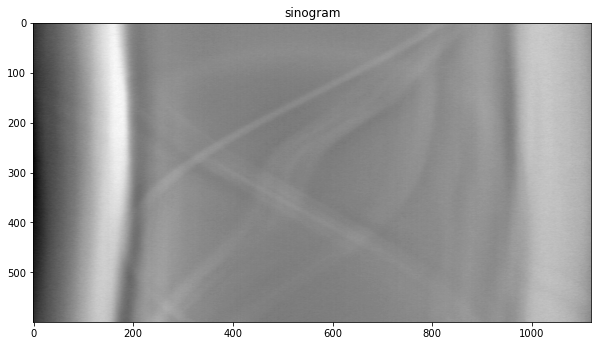

In [10]:
plt.imshow(np.sum(proj, axis=1), cmap="gray")
plt.title("sinogram")
plt.show()

In [ ]:
plt.imshow(np.sum(proj, axis=2), cmap="gray")
plt.title("sinogram")
plt.show()

In [ ]:
ImageSliceViewer3D(np.transpose(proj, (1,2,0)))#Look at slice 439

In [ ]:
recon = tomopy.recon(np.expand_dims(proj[439,:,:], axis=1), theta, center=rot_center, algorithm='gridrec', ncore=32)
plt.imshow(recon[0, :, :])
ImageSliceViewer3D(recon)

In [ ]:
np.save("projections.npy", proj, allow_pickle=False, fix_imports = True)

In [ ]:
np.save("theta.npy", theta, allow_pickle=False, fix_imports = True)